In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
from keras.preprocessing.text import text_to_word_sequence
from nltk import WordNetLemmatizer

In [ ]:
df = pd.read_csv('train_cleaned.csv')

In [ ]:
def preprocess(df):
    
    # Lowercase letters
    df['comment_text'] = df['comment_text'].str.lower()
    
    # Remove special characters (i.e. @, $, %)
    df['comment_text'] = df['comment_text'].str.replace("[^a-z0-9!@#\$%\^\&\*_\-,\.' ]", " ") 
    
    # Remove punctuations - if you don't want to remove this, comment below out
    df['comment_text'] = df['comment_text'].str.replace('[^\w\s]', "")
    
    # Remove random numbers
    df['comment_text'] = df['comment_text'].str.replace("[^a-z' ]", "")
    
    # Remove repeating characters and extra spaces 
    # Examples: 'whaaat' --> 'what' OR 'hello   bye' --> 'hello bye'
    # Note: This does change words like "look" to "lok" cuz of the double letters, 
    # if we don't want this, we can remove the \w in the regex pattern below.
    repeat_pattern = re.compile(r'(\w|\s)\1*')
    match_substitution = r'\1'
    df['comment_text'] = df['comment_text'].apply(lambda x: repeat_pattern.sub(match_substitution, x))
    
    return df

In [ ]:
df.isna().sum()

id                0
comment_text      0
toxic             0
severe_toxic      0
obscene           0
threat            0
insult            0
identity_hate     0
final_toxicity    0
dtype: int64

In [ ]:
df.dropna(axis=0,inplace=True)

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,final_toxicity
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,daw he matches this background colour im semin...,0,0,0,0,0,0,0
2,000113f07ec002fd,hey man im realy not trying to edit war its ju...,0,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i cant make any real sugestions on impro...,0,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,0


In [ ]:
#Sample an equal proportion of toxic and nontoxic comments
df = df.groupby('final_toxicity').apply(lambda x: x.iloc[0:16225,:]).set_index('id')

In [ ]:
df

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,final_toxicity
id,,,,,,,,
0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,0
000103f0d9cfb60f,daw he matches this background colour im semin...,0,0,0,0,0,0,0
000113f07ec002fd,hey man im realy not trying to edit war its ju...,0,0,0,0,0,0,0
0001b41b1c6bb37e,more i cant make any real sugestions on impro...,0,0,0,0,0,0,0
0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
fef4cf7ba0012866,our previous conversation you fucking shit ea...,1,0,1,0,1,1,1
ff39a2895fc3b40e,you are a mischievious pubic hair,1,0,0,0,1,0,1
ffa33d3122b599d6,your absurd edits your absurd edits on great w...,1,0,1,0,1,0,1


In [ ]:
def find_toxic_words(df):
    
    # Using regex, pull out a new words column, the words from the body of each email
    df['words'] = df['comment_text'].replace(r'[^0-9a-zA-Z]',' ').str.split()

    # Split training DF into a DF of Toxic emails and a DF of Ham emails
    toxic_train = df[df['final_toxicity'] == 1]
    nontoxic_train = df[df['final_toxicity'] == 0]
    
    toxic_words = toxic_train['words']
    nontoxic_words = nontoxic_train['words']
    
    # Count the number of times a word appears in a Spam email or a Ham email
    toxic_count = dict()
    nontoxic_count = dict()

    for text in toxic_words:
        for word in text:
            if word in toxic_count:
                toxic_count[word] += 1
            else:
                toxic_count[word] = 1
                
    for text in nontoxic_words:
        for word in text:
            if word in nontoxic_count:
                nontoxic_count[word] += 1
            else:
                nontoxic_count[word] = 1

    # Sort word dictionaries to top 500 words
    sorted_toxic_words = sorted(toxic_count, key=toxic_count.__getitem__, reverse=True)[0:500]
    sorted_nontoxic_words = sorted(nontoxic_count, key=nontoxic_count.__getitem__, reverse=True)[0:500]
    
    # Remove words from spam word list that are in both top 500 lists
    for word in sorted_toxic_words:
        if word in sorted_nontoxic_words:
            sorted_toxic_words.remove(word)

    df.drop('words', axis = 1, inplace=True)
    
    return sorted_toxic_words

In [ ]:
sorted_toxic_words = find_toxic_words(df)

In [ ]:
#fix spelling on certain words - will make model less overfit on training but possibly more accurate on future data
#BIAS
words = ['wil', 'fagot', 'ben', 'bulshit', 'se', 'ashole', 'bals', 'kil', 'litle', 'fagots', 'yourselfgo', 'hel', 'wel', 'tel',
         'nobs', 'kep', 'bobs', 'smal', 'bitchesfuck', 'sexsex', 'youfuck', 'bitchfuck', 'mothjer', 'useles', 'baned', 'asfuck',
         'acount', 'tomy','securityfuck', 'smels', 'blody', 'fartchina', 'cocksucking', 'gona', 'shitfuck', 'centraliststupid',
         'niple', 'ned', 'tel', 'lok', 'beter', 'pusy', 'fucksex']
spelling = ['will', 'faggot', 'been', 'bullshit', 'see', 'asshole', 'balls','kill', 'little','faggots', 'yourself go', 
'hell', 'well', 'tell', 'noobs','keep', 'boobs', 'small', 'bitches fuck', 'sex sex', 'you fuck', 'bitch fuck', 'mother', 
'useless', 'banned', 'as fuck', 'account', 'to my', 'security fuck', 'smells', 'bloody', 'fart china', 'cock sucking', 
'gonna', 'shit fuck', 'centralist stupid', 'nipple', 'need', 'tell', 'look', 'better', 'pussy', 'fuck sex']

for i in range(len(words)):
  if words[i] in sorted_toxic_words:
    sorted_toxic_words.remove(words[i])
    sorted_toxic_words.append(spelling[i])

In [ ]:
#remove preposition/structural words that are potentially common in all positions
#BIAS
words = ['the', 'i', 'is', 'are', 'in', 'as','my', 'me', 'for', 'be', 'what', 'if', 'just', 'or', 'who', 'by', 'and',
         'on','was','can','he', 'from', 'yourself', 'youre', 'at', 'one','has', 'being', 'than', 'were', 'also', 'do',
         'so', 'go', 'page', 'their', 'does', 'where', 'those', 'these', 'youi', 'else', 'will', 'been', 'see', 'am', 'have', 'like']
for i in range(len(words)):
  if words[i] in sorted_toxic_words:
    sorted_toxic_words.remove(words[i])

In [ ]:
sorted_toxic_words

['fuck',
 'dont',
 'shit',
 'wikipedia',
 'niger',
 'fucking',
 'suck',
 'u',
 'hate',
 'no',
 'gay',
 'die',
 'fat',
 'moron',
 'cunt',
 'talk',
 'how',
 'bitch',
 'here',
 'stupid',
 'sucks',
 'wiki',
 'think',
 'jew',
 'pig',
 'should',
 'now',
 'penis',
 'dick',
 'time',
 'would',
 'even',
 'other',
 'please',
 'wanker',
 'only',
 'fag',
 'going',
 'bark',
 'idiot',
 'sex',
 'cock',
 'piece',
 'hey',
 'say',
 'aids',
 'way',
 'dickhead',
 'bastard',
 'admin',
 'edits',
 'fucker',
 'own',
 'shut',
 'take',
 'damn',
 'eat',
 'loser',
 'love',
 'big',
 'ever',
 'rape',
 'oh',
 'very',
 'd',
 'homo',
 'huge',
 'editing',
 'information',
 'delete',
 'cocksucker',
 'ban',
 'work',
 'someone',
 'pop',
 'read',
 'super',
 'real',
 'use',
 'things',
 'dog',
 'hitler',
 'butsecks',
 'must',
 'world',
 'mother',
 'first',
 'fgt',
 'admins',
 'day',
 'guys',
 'bastered',
 'making',
 'leave',
 'bush',
 'site',
 'let',
 'dumb',
 'since',
 'anal',
 'try',
 'crap',
 'around',
 'find',
 'heil',
 'a

In [ ]:
def count_toxic_words(df, words):
  for word in words:
    count = df['comment_text'].apply(lambda x: x).str.findall(word)
    for x in range(len(count)):
      count[x] = len(count[x])
    df[word] = count
  return df

In [ ]:
#This may take a while to run
count_toxic_words(df, sorted_toxic_words)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,final_toxicity,fuck,dont,shit,wikipedia,niger,fucking,suck,u,hate,no,gay,die,fat,moron,cunt,talk,how,bitch,here,stupid,sucks,wiki,think,jew,pig,should,now,penis,dick,time,would,even,...,hard,havent,death,o,stay,faggot,bullshit,asshole,balls,kill,little,faggots,yourself go,hell,tell,noobs,keep,boobs,small,bitches fuck,sex sex,you fuck,bitch fuck,useless,banned,as fuck,account,to my,security fuck,smells,bloody,fart china,cock sucking,gonna,nipple,need,look,better,pussy,fuck sex
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
000103f0d9cfb60f,daw he matches this background colour im semin...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
000113f07ec002fd,hey man im realy not trying to edit war its ju...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0001b41b1c6bb37e,more i cant make any real sugestions on impro...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,9,0,3,0,0,0,0,0,0,0,0,2,0,0,1,1,0,0,1,1,0,0,0,0,0,...,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fef4cf7ba0012866,our previous conversation you fucking shit ea...,1,0,1,0,1,1,1,20,0,5,2,1,18,0,68,0,3,0,0,2,0,0,0,0,2,1,1,0,2,1,0,0,1,2,0,0,0,0,0,...,0,0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ff39a2895fc3b40e,you are a mischievious pubic hair,1,0,0,0,1,0,1,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ffa33d3122b599d6,your absurd edits your absurd edits on great w...,1,0,1,0,1,0,1,1,0,3,0,0,1,0,18,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df['total toxic'] = np.sum(df.iloc[:,8:281], axis = 1)

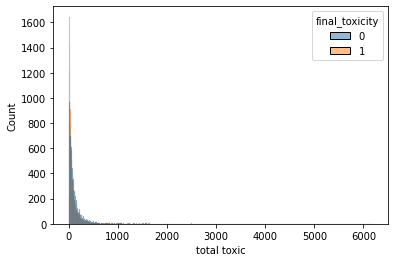

In [ ]:
import seaborn as sns
sns.histplot(data=df, x="total toxic", hue = 'final_toxicity');

In [ ]:
x_train = df.iloc[:,8:282].astype('int')
y_train = df['final_toxicity']

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn import preprocessing
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Dense(200, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(25, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit(x_train,y_train, epochs=20)
print('Accuracy of Training Set: ', model.evaluate(x_train,y_train)[1])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 200)               55000     
_________________________________________________________________
dense_13 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_14 (Dense)             (None, 25)                2525      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 26        
Total params: 77,651
Trainable params: 77,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1015/1015 [==============================] - 2s 2ms/step - loss: 0.4026 - accuracy: 0.8124
Epoch 2/20
1015/1015 [==============================] - 2s 2ms/step - loss: 0.3302 - accuracy: 0.8537
Epoch 3/20
1015/1015 [======================

In [ ]:
x_test = pd.read_csv('test_filtered.csv')
y_test = pd.read_csv('test_labels_new_column.csv')
y_test = y_test['final_toxicity']

In [ ]:
x_test = preprocess(x_test)
x_test.head()

,id,comment_text
0,0001ea8717f6de06,thank you for understanding i think very highl...
1,000247e83dcc1211,dear god this site is horible
2,0002f87b16116a7f,somebody wil invariably try to ad religion re...
3,0003e1cccfd5a40a,it says it right there that it is a type the ...
4,00059ace3e3e9a53,before ading a new product to the list make s...


In [ ]:
#This may take a while to run
count_toxic_words(x_test, sorted_toxic_words)

,id,comment_text,fuck,dont,shit,wikipedia,niger,fucking,suck,u,hate,no,gay,die,fat,moron,cunt,talk,how,bitch,here,stupid,sucks,wiki,think,jew,pig,should,now,penis,dick,time,would,even,other,please,wanker,only,fag,going,...,havent,death,o,stay,faggot,bullshit,asshole,balls,kill,little,faggots,yourself go,hell,tell,noobs,keep,boobs,small,bitches fuck,sex sex,you fuck,bitch fuck,useless,banned,as fuck,account,to my,security fuck,smells,bloody,fart china,cock sucking,gonna,nipple,need,look,better,pussy,fuck sex,total toxic
0,0001ea8717f6de06,thank you for understanding i think very highl...,0,0,0,0,0,0,0,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46.0
1,000247e83dcc1211,dear god this site is horible,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0
2,0002f87b16116a7f,somebody wil invariably try to ad religion re...,0,0,0,0,0,0,0,9,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,...,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,131.0
3,0003e1cccfd5a40a,it says it right there that it is a type the ...,0,0,0,0,0,0,0,13,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,153.0
4,00059ace3e3e9a53,before ading a new product to the list make s...,0,0,0,1,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,111.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63973,fff8f64043129fa2,jerome i se you never got around to this i m ...,0,0,0,0,0,0,0,14,0,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,...,0,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,193.0
63974,fff9d70fe0722906,lucky bastard htp wikimediafoundationorg wiki...,0,0,0,1,0,0,0,7,0,3,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68.0
63975,fffa8a11c4378854,shame on you al you want to speak about gays ...,0,0,0,0,0,0,0,4,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27.0
63976,fffac2a094c8e0e2,mel gibson is a nazi bitch who makes shity mov...,0,0,1,0,0,0,0,4,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48.0


In [ ]:
x_test['total toxic'] = np.sum(x_test.iloc[:,2:276], axis = 1)
x_test.head()

,id,comment_text,fuck,dont,shit,wikipedia,niger,fucking,suck,u,hate,no,gay,die,fat,moron,cunt,talk,how,bitch,here,stupid,sucks,wiki,think,jew,pig,should,now,penis,dick,time,would,even,other,please,wanker,only,fag,going,...,havent,death,o,stay,faggot,bullshit,asshole,balls,kill,little,faggots,yourself go,hell,tell,noobs,keep,boobs,small,bitches fuck,sex sex,you fuck,bitch fuck,useless,banned,as fuck,account,to my,security fuck,smells,bloody,fart china,cock sucking,gonna,nipple,need,look,better,pussy,fuck sex,total toxic
0,0001ea8717f6de06,thank you for understanding i think very highl...,0,0,0,0,0,0,0,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,92.0
1,000247e83dcc1211,dear god this site is horible,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20.0
2,0002f87b16116a7f,somebody wil invariably try to ad religion re...,0,0,0,0,0,0,0,9,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,...,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,262.0
3,0003e1cccfd5a40a,it says it right there that it is a type the ...,0,0,0,0,0,0,0,13,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,306.0
4,00059ace3e3e9a53,before ading a new product to the list make s...,0,0,0,1,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,222.0


In [ ]:
y_pred = pd.read_csv('prediction.csv')
y_pred = y_pred['final_toxicity']

In [ ]:
y_pred.flatten()

array([0.94232714, 0.8420719 , 0.96960986, ..., 0.99796164, 0.99967   ,
       0.9154229 ], dtype=float32)

In [ ]:
y_pred = y_pred.flatten()
for i in range(len(y_pred)):
  if y_pred[i] >= 0.5:
    y_pred[i] = 1
  else:
    y_pred[i] = 0
y_pred = y_pred.astype('int')

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8081996936446904

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred, average='binary')

0.889316033958033

In [ ]:
from sklearn.metrics import precision_score
precision_score(y_test, y_pred, average='binary')

0.324071912211067

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='binary')

0.47503743315508024

In [ ]:
prediction = pd.DataFrame(index=x_test.id)
prediction['final_toxicity'] = y_pred

In [ ]:
y_test.value_counts

<bound method IndexOpsMixin.value_counts of 0        0
1        0
2        0
3        0
4        0
        ..
63973    0
63974    0
63975    0
63976    1
63977    0
Name: final_toxicity, Length: 63978, dtype: int64>

In [ ]:
prediction.value_counts

<bound method DataFrame.value_counts of                   final_toxicity
id                              
0001ea8717f6de06               0
000247e83dcc1211               0
0002f87b16116a7f               0
0003e1cccfd5a40a               0
00059ace3e3e9a53               0
...                          ...
fff8f64043129fa2               0
fff9d70fe0722906               1
fffa8a11c4378854               1
fffac2a094c8e0e2               1
fffb5451268fb5ba               0

[63978 rows x 1 columns]>

In [ ]:
prediction.reset_index().to_csv('prediction.csv', index=False)

In [ ]:
y_pred

array([0, 1, 1, ..., 1, 1, 0])